<a href="https://colab.research.google.com/github/DonaFidele/Budget-App/blob/main/KNN_winequality_white.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nous allons travailler avec un jeu de données qui contient des informations physico-chimiques de vins portugais (vinho verde), ainsi que leur qualité telle que notée par des humains.

Le problème, sur ces données, est de prédire automatiquement la qualité sur la base de ces informations, afin d’assister le travail d’évaluation des œnologues, d’améliorer la production de vin, et de cibler le goût des consommateurs sur des marchés de niche.

In [1]:
# chargeons et observons nos données
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv('winequality-white.csv', sep=";")
print(data.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6 

In [2]:
# les points et les étiquettes

X=data[data.columns[:-1]].values
y=data['quality'].values


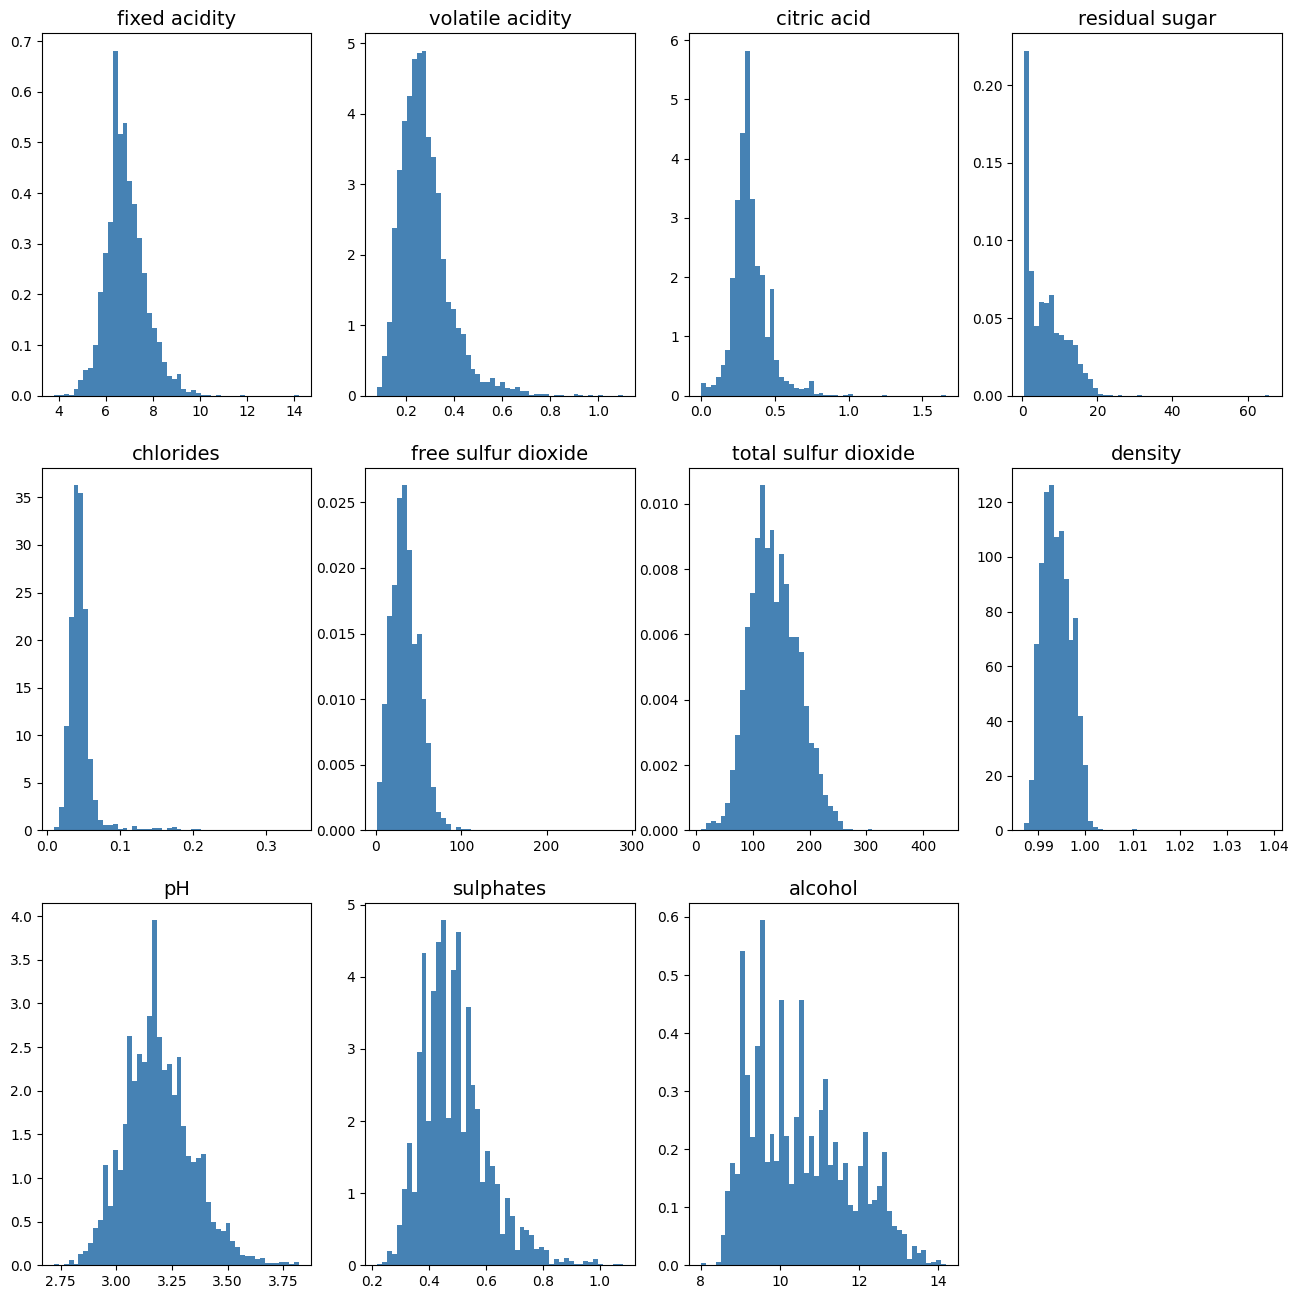

In [4]:
# affichons un histogramme pour chacune de nos variables :

fig = plt.figure(figsize=(16, 16))
for feat_idx in range(X.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(X[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(data.columns[feat_idx], fontsize=14)


On remarque en particulier que ces variables prennent des valeurs dans des ensembles différents. Par exemple, “sulphates” varie de 0 à 1 tandis que “total sulfur dioxide” varie de 0 à 440. Il va donc nous falloir standardiser les données pour que la deuxième ne domine pas complètement la première.

Nous allons commencer par transformer ce problème en un problème de classification : il s’agira de séparer les bons vins des vins médiocres :

In [5]:
#0 si y<0 , 1 sinon
y_class = np.where(y<6, 0, 1)

In [6]:
# Séparons nos données en un jeu d’entraînement et un jeu de test

from sklearn import model_selection
X_train, X_test, y_train, y_test =model_selection.train_test_split(X, y_class,test_size=0.3 )

Nous pouvons maintenant standardiser les données d’entraînement et appliquer la même transformation aux données de test :

In [7]:
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

On peut visualiser de nouveau les données pour vérifier que les différentes variables prennent des valeurs qui ont maintenant des ordres de grandewur similaires.

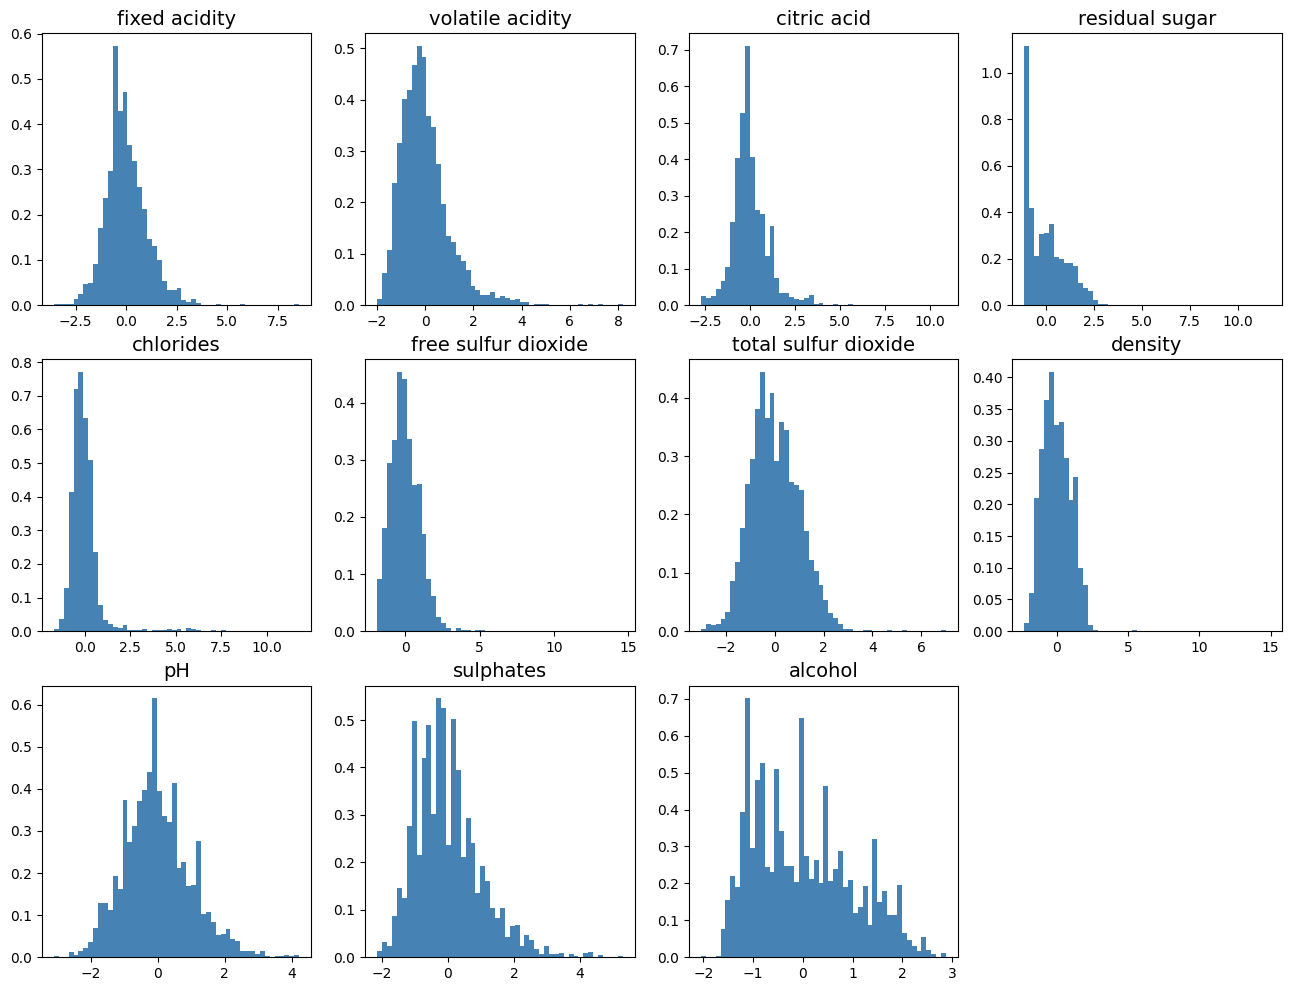

In [8]:
fig = plt.figure(figsize=(16, 12))
for feat_idx in range(X_train_std.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(X_train_std[:, feat_idx], bins=50, color = 'steelblue', density=True, edgecolor='none')
    ax.set_title(data.columns[feat_idx], fontsize=14)


On remarque maintenant que les variables prennent toutes des valeurs entre -2 et 8.

Nous allons maintenant utiliser la méthode "GridSearchCV" pour faire une validation croisée du paramètre k d’un kNN (le nombre de plus proches voisins) sur le jeu d’entraînement :

In [9]:
from sklearn import neighbors, metrics

# Fixer les valeurs des hyperparamètres à tester
param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}

# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = 'accuracy'

# Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
clf = model_selection.GridSearchCV(
    neighbors.KNeighborsClassifier(), # un classifieur kNN
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
)

# Optimiser ce classifieur sur le jeu d'entraînement
clf.fit(X_train_std, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(clf.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        clf.cv_results_['mean_test_score'], # score moyen
        clf.cv_results_['std_test_score'],  # écart-type du score
        clf.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_neighbors': 3}
Résultats de la validation croisée :
accuracy = 0.768 (+/-0.014) for {'n_neighbors': 3}
accuracy = 0.759 (+/-0.027) for {'n_neighbors': 5}
accuracy = 0.761 (+/-0.036) for {'n_neighbors': 7}
accuracy = 0.755 (+/-0.029) for {'n_neighbors': 9}
accuracy = 0.759 (+/-0.028) for {'n_neighbors': 11}
accuracy = 0.757 (+/-0.031) for {'n_neighbors': 13}
accuracy = 0.757 (+/-0.032) for {'n_neighbors': 15}


La meilleure performance (~0.768) est ici atteinte avec 3 voisins.

Nous pouvons maintenant regarder la performance sur le jeu de test. GridSearchCV a automatiquement ré-entraîné le meilleur modèle sur l’intégralité du jeu d’entraînement,

In [12]:
y_pred = clf.predict(X_test_std)
print(f"\nSur le jeu de test : {round(metrics.accuracy_score(y_test, y_pred),3)}")



Sur le jeu de test : 0.759
